<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/tensorflow/rice_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify 5 types of rice

[Kaggle Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)

# import data and helpers

In [2]:
# Download Helper File & Rice Data
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
!wget https://www.dropbox.com/s/sd69bn3a5iq70wk/rice-images.zip?dl=0

--2022-06-03 15:59:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-03 15:59:44 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2022-06-03 15:59:44--  https://www.dropbox.com/s/sd69bn3a5iq70wk/rice-images.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sd69bn3a5iq70wk/rice-images.zip [followin

In [3]:
# Imports
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
# unzip rice-data
# I preprocessed the data by splitting them into testing and training 
#   directories each at a different percentage to help train faster.
unzip_data('rice-images.zip?dl=0')

In [10]:
# training data at 3%
walk_through_dir('train_3')

There are 5 directories and 1 images in 'train_3'.
There are 0 directories and 450 images in 'train_3/Jasmine'.
There are 0 directories and 450 images in 'train_3/Ipsala'.
There are 0 directories and 450 images in 'train_3/Arborio'.
There are 0 directories and 450 images in 'train_3/Karacadag'.
There are 0 directories and 450 images in 'train_3/Basmati'.


# Data Preprocessing

In [22]:
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32
RANDOM_STATE = 42
LABEL_NAMES = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [97]:
train_3_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'train_3',
    label_mode='categorical',
    image_size= IMG_SHAPE,
    batch_size= BATCH_SIZE
)

train_5_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'train_5',
    label_mode='categorical',
    image_size= IMG_SHAPE,
    batch_size= BATCH_SIZE
)

train_80_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'train_80',
    label_mode='categorical',
    image_size= IMG_SHAPE,
    batch_size= BATCH_SIZE
)

test_20_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'test_20',
    label_mode='categorical',
    image_size= IMG_SHAPE,
    batch_size= BATCH_SIZE
)




Found 2250 files belonging to 5 classes.
Found 3750 files belonging to 5 classes.
Found 6000 files belonging to 5 classes.
Found 15000 files belonging to 5 classes.


## Create data augmentation layer 

In [95]:
data_aug_dial = 0.2
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(data_aug_dial),
  tf.keras.layers.RandomZoom(data_aug_dial),
  tf.keras.layers.RandomWidth(data_aug_dial),
  tf.keras.layers.RandomHeight(data_aug_dial),
], name = 'data_augmetation_layer')

# Visualize Data

In [91]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

# function to view randoms samples 
def show_random_image():

  random_class = random.choice(LABEL_NAMES)
  target_dir = f'train_80/{random_class}'
  random_image = random.choice(os.listdir(target_dir))
  image_path = f'{target_dir}/{random_image}'
  image = mpimg.imread(image_path)

  plt.figure(figsize=(10, 15))

  # Regular Image
  plt.subplot(1, 2, 1)
  plt.title(f'Regular Image (type: {random_class})')
  plt.axis(False)
  plt.imshow(image)

  # Augmented Image
  augmented_image = data_augmentation(tf.expand_dims(image, axis=0), training=True)
  plt.subplot(1, 2, 2)
  plt.title(f'Augmented Image')
  plt.axis(False)
  plt.imshow(tf.squeeze(augmented_image/255.))


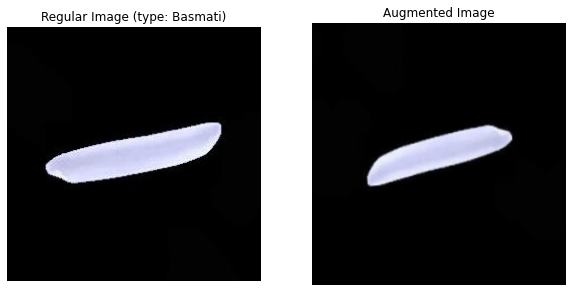

In [93]:
show_random_image()

# Model Creation

* The first model will be the base model using transfer learning.  

* Once the feature extraction base model is created, we can use unfreeze some  layers to fine tune.

* We start using small incremented of data (3%) and will increase daeta as the model becomes complex.

* We'll use EfficientNetB0 for now and might use different model based off results

In [100]:
# Model_1 (Feature Extraction)

input_shape = IMG_SHAPE + (3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape= input_shape, name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

# Feature extractions
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)


model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


history_1 = model_1.fit(
    train_3_percent,
    epochs=5, 
    steps_per_epoch=len(train_3_percent),
    validation_data=test_20_percent,
    validation_steps=int(.25*len(test_20_percent))
)

Epoch 1/5
71/71 [==============================] - 51s 477ms/step - loss: 0.6279 - accuracy: 0.8511 - val_loss: 0.2918 - val_accuracy: 0.9589
Epoch 2/5
71/71 [==============================] - 25s 345ms/step - loss: 0.1931 - accuracy: 0.9667 - val_loss: 0.1719 - val_accuracy: 0.9714
Epoch 3/5
71/71 [==============================] - 25s 354ms/step - loss: 0.1404 - accuracy: 0.9658 - val_loss: 0.1476 - val_accuracy: 0.9696
Epoch 4/5
71/71 [==============================] - 23s 321ms/step - loss: 0.1043 - accuracy: 0.9782 - val_loss: 0.1261 - val_accuracy: 0.9690
Epoch 5/5
71/71 [==============================] - 23s 323ms/step - loss: 0.1038 - accuracy: 0.9702 - val_loss: 0.1162 - val_accuracy: 0.9720


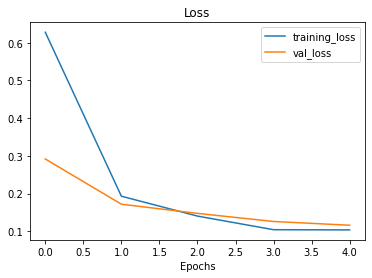

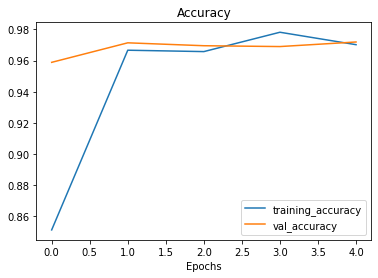

In [101]:
plot_loss_curves(history_1)

In [104]:
# Evaluate and save full testing set
model_1_results = model_1.evaluate(test_20_percent)

469/469 [==============================] - 33s 70ms/step - loss: 0.1202 - accuracy: 0.9703


Model_1 right off the bat has a high accuracy score without any fine tuning on only 3 percent of the dataset. On the full validation (3000 samples) the model was able to retain it's high accuracy percentage of 97%

Let's try some fine tuning